## What's different from Version 1
We branched out to version 2 because the visiblity metric of rays are not a representative method for coverage. We seek for a better visiblity and coverage metric here. 
Also, we aim to make a baseline greedy algorithm here.

In [1]:
# Install the required packages
! pip install shapely matplotlib

In [12]:
## Import Packages
import os
import random
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from shapely.affinity import rotate
import matplotlib.pyplot as plt
from polygenerator import random_convex_polygon
from collections import defaultdict

# --- Core Modules (Classes) ---

class Environment:
    """
    Defines the simulation environment, which is a polygonal boundary.
    """
    def __init__(self, n_vertices=12):
        self.polygon_coords = random_convex_polygon(n_vertices)
        self.polygon = Polygon(self.polygon_coords)
        if not self.polygon.is_valid:
            raise ValueError("The generated polygon is invalid.")
        print(f"🗺️  Environment created with {n_vertices} vertices.")

    def get_bounds(self):
        return self.polygon.bounds

class TrackedObject:
    """
    Represents an object that moves along a path within the environment.
    """
    def __init__(self, environment_polygon, object_id, n_waypoints=5, short_side_length=0.05, rectangle_ratio=6, seed=None):
        self.id = object_id
        self.env_poly = environment_polygon
        self.n_waypoints = n_waypoints
        self.short_side = short_side_length
        self.long_side = rectangle_ratio * self.short_side
        self.seed = seed
        self.waypoints = []
        self.path = []
        self.shapes = []
        self._generate_path()
        self._create_shapes()
        print(f"  -> 🎯 TrackedObject ID {self.id} created with a path of {n_waypoints} steps.")

    def _generate_path(self):
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)
        half_short = self.short_side / 2.0
        half_long = self.long_side / 2.0
        margin = np.sqrt(half_long**2 + half_short**2)
        safe_sampling_area = self.env_poly.buffer(-margin)
        if safe_sampling_area.is_empty:
            raise ValueError("Object size is too large for the environment.")
        minx, miny, maxx, maxy = safe_sampling_area.bounds
        while len(self.waypoints) < self.n_waypoints:
            point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if safe_sampling_area.contains(point):
                self.waypoints.append(point)
        pts_arr = np.array([(p.x, p.y) for p in self.waypoints])
        dist_matrix = np.sqrt(np.sum((pts_arr[:, np.newaxis, :] - pts_arr[np.newaxis, :, :])**2, axis=-1))
        unvisited = set(range(self.n_waypoints))
        path_indices = [0]
        unvisited.remove(0)
        while unvisited:
            last_idx = path_indices[-1]
            next_idx = min(unvisited, key=lambda i: dist_matrix[last_idx, i])
            path_indices.append(next_idx)
            unvisited.remove(next_idx)
        self.path = [self.waypoints[i] for i in path_indices]

    def _create_shapes(self):
        half_short = self.short_side / 2.0
        half_long = self.long_side / 2.0
        for point in self.path:
            rectangle = box(-half_long, -half_short, half_long, half_short)
            rotated_rectangle = rotate(rectangle, random.uniform(0, 360), origin='center')
            moved_rectangle = Polygon([(p[0] + point.x, p[1] + point.y) for p in rotated_rectangle.exterior.coords])
            self.shapes.append(moved_rectangle)

class Camera:
    """
    Represents a camera sensor. Identifies *which* object was hit.
    """
    def __init__(self, position, camera_id, camera_range=3.0, n_rays=36):
        self.id = camera_id  # Store the ID
        self.position = position
        self.range = camera_range
        self.n_rays = n_rays
        self.rays = []
        print(f"  -> 📷 Camera created at ({position.x:.2f}, {position.y:.2f}).")

    def cast_rays(self, environment_polygon, obstacles):
        """Casts rays, storing the ID of the hit object."""
        self.rays = []
        angles = np.linspace(0, 360, self.n_rays, endpoint=False)
        all_boundaries = obstacles + [environment_polygon.boundary]
        for angle in angles:
            end_x = self.position.x + self.range * np.cos(np.radians(angle))
            end_y = self.position.y + self.range * np.sin(np.radians(angle))
            ray = LineString([self.position, (end_x, end_y)])
            intersection_points = []
            for boundary in all_boundaries:
                if ray.intersects(boundary):
                    intersection = ray.intersection(boundary)
                    if hasattr(intersection, 'geoms'):
                        for geom in intersection.geoms:
                            if geom.geom_type == 'Point':
                                intersection_points.append(geom)
                            elif geom.geom_type == 'LineString':
                                intersection_points.append(Point(geom.coords[0]))
                    elif not intersection.is_empty:
                        if intersection.geom_type == 'Point':
                            intersection_points.append(intersection)
                        elif intersection.geom_type == 'LineString':
                            intersection_points.append(Point(intersection.coords[0]))
            end_point = ray.coords[1]
            hit_id = None
            if intersection_points:
                closest_point = min(intersection_points, key=lambda p: self.position.distance(p))
                end_point = closest_point.coords[0]
                for i, obs in enumerate(obstacles):
                    if obs.distance(closest_point) < 1e-9:
                        hit_id = i
                        break
            self.rays.append([self.position.coords[0], end_point, hit_id])

class Scene:
    """
    Manages the setup of the simulation and updates its state over time.
    """
    def __init__(self, n_objects=2, n_waypoints=10, n_cameras=3, seed=42):
        print("🚀 Initializing Scene Setup...")
        self.env = Environment()
        self.objects = []
        self.cameras = []
        self.seed = seed
        self.num_timesteps = n_waypoints
        
        self._generate_objects(n_objects, n_waypoints)
        self._place_cameras(n_cameras)
        print("✅ Scene setup complete!")
        
    def _generate_objects(self, n_objects, n_waypoints):
        print(f"🏃 Generating {n_objects} tracked objects...")
        for i in range(n_objects):
            obj_seed = self.seed + i if self.seed is not None else None
            obj = TrackedObject(self.env.polygon, object_id=i, n_waypoints=n_waypoints, seed=obj_seed)
            self.objects.append(obj)
            
    def _place_cameras(self, n_cameras):
        print(f"🎥 Placing {n_cameras} cameras...")
        if self.seed is not None:
            random.seed(self.seed + 100)
        all_future_obstacles = [shape for obj in self.objects for shape in obj.shapes]
        minx, miny, maxx, maxy = self.env.get_bounds()
        while len(self.cameras) < n_cameras:
            point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            is_in_env = self.env.polygon.contains(point)
            is_on_obstacle = any(obs.contains(point) for obs in all_future_obstacles)
            if is_in_env and not is_on_obstacle:
                cam_id = len(self.cameras)
                self.cameras.append(Camera(point, camera_id=cam_id))

    def update_scene_at_timestep(self, time_step):
        if not (0 <= time_step < self.num_timesteps):
            print(f"⚠️ Warning: Time step {time_step} is out of bounds.")
            return
        current_obstacles = [obj.shapes[time_step] for obj in self.objects]
        for cam in self.cameras:
            cam.cast_rays(self.env.polygon, current_obstacles)

class VisibilityCalculator:
    """
    Calculates visibility scores for objects in the scene.
    """
    def __init__(self, scene):
        self.scene = scene

    # def calculate_at_timestep(self):
    #     """Counts the number of rays from all cameras hitting each object."""
    #     scores = {obj.id: 0 for obj in self.scene.objects}
    #     all_rays = [ray for cam in self.scene.cameras for ray in cam.rays]
    #     for ray in all_rays:
    #         hit_id = ray[2]
    #         if hit_id is not None:
    #             scores[hit_id] += 1
    #     return scores
    
    def calculate_at_timestep(self):
        """
        Counts rays from each camera hitting each object.
        Returns a nested dictionary: {object_id: {camera_id: count}}
        """
        # Use a defaultdict for easier nested dictionary creation
        scores = defaultdict(lambda: defaultdict(int))

        # Iterate through each camera to keep track of its ID
        for cam in self.scene.cameras:
            for ray in cam.rays:
                hit_id = ray[2]
                if hit_id is not None:
                    # Increment the count for the specific object_id and camera_id
                    scores[hit_id][cam.id] += 1
        
        # Convert back to a regular dict for a cleaner output, if desired
        return dict(scores)

class Visualizer:
    def __init__(self, scene):
        self.scene = scene
    
    def plot_timestep(self, time_step, visibility_scores, save_fig=False, output_dir="."):
        fig, ax = plt.subplots(figsize=(10, 10))
        object_colors = ['#FF1493', '#00BFFF', '#32CD32', '#FFD700', '#9400D3', '#FF4500']
        
        # Plot Environment
        x, y = self.scene.env.polygon.exterior.xy
        ax.plot(x, y, color='black', linewidth=2, label='Environment Boundary')
        
        # Plot Tracked Objects
        for i, obj in enumerate(self.scene.objects):
            primary_color_hex = object_colors[i % len(object_colors)]
            
            # Plot the simple path for context
            path_x = [p.x for p in obj.path]
            path_y = [p.y for p in obj.path]
            ax.plot(path_x, path_y, 'o--', color=primary_color_hex, markersize=5, alpha=0.3)

            # Plot the object's current position
            current_shape = obj.shapes[time_step]
            sx, sy = current_shape.exterior.xy
            ax.fill(sx, sy, alpha=0.9, color=primary_color_hex, label=f'Object {i+1} Position')

            # *** START OF CHANGE ***
            # 1. Get the geometric center (centroid) of the object
            centroid = current_shape.centroid
            
            # 2. Get the score
            score = visibility_scores.get(obj.id, 0)
            
            # 3. Display the text right on the centroid
            ax.text(centroid.x, centroid.y, f"Hits: {score}",
                    ha='center', va='center', # Center the text block on the point
                    fontweight='bold', fontsize=9,
                    color='white',
                    bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.5),
                    zorder=100)
            # *** END OF CHANGE ***

        # Plot Cameras and their current rays
        for cam in self.scene.cameras:
            ax.plot(cam.position.x, cam.position.y, 'ro', markersize=8, label=cam.id)
            for ray in cam.rays:
                start, end, hit_id = ray
                ray_color = 'red' if hit_id is not None else 'cyan'
                line = LineString([start, end])
                lx, ly = line.xy
                ax.plot(lx, ly, color=ray_color, linewidth=0.7)

        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"Simulation at Time Step: {time_step}", fontsize=16)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        if save_fig:
            os.makedirs(output_dir, exist_ok=True)
            filepath = os.path.join(output_dir, f"timestep_{time_step:03d}.png")
            plt.savefig(filepath)
            plt.close(fig)
        else:
            plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    SAVE_PLOTS = True
    OUTPUT_DIRECTORY = "simulation_centered_text"
    NUMBER_OF_TIMESTEPS = 1

    simulation_scene = Scene(n_objects=2, n_waypoints=NUMBER_OF_TIMESTEPS, n_cameras=3, seed=42)
    visualizer = Visualizer(simulation_scene)
    calculator = VisibilityCalculator(simulation_scene)

    print(f"\n🎬 Running simulation for {NUMBER_OF_TIMESTEPS} time steps...")

    for t in range(simulation_scene.num_timesteps):
        simulation_scene.update_scene_at_timestep(t)
        visibility_scores = calculator.calculate_at_timestep()
        print(f"  -> 🖼️  Generating frame {t}... Visibility Scores: {visibility_scores}")
        visualizer.plot_timestep(t, visibility_scores=visibility_scores, save_fig=SAVE_PLOTS, output_dir=OUTPUT_DIRECTORY)
    
    if SAVE_PLOTS:
        print(f"\n✅ Simulation complete! {simulation_scene.num_timesteps} frames saved to '{OUTPUT_DIRECTORY}'.")


🚀 Initializing Scene Setup...
🗺️  Environment created with 12 vertices.
🏃 Generating 2 tracked objects...
  -> 🎯 TrackedObject ID 0 created with a path of 1 steps.
  -> 🎯 TrackedObject ID 1 created with a path of 1 steps.
🎥 Placing 3 cameras...
  -> 📷 Camera created at (0.58, 0.68).
  -> 📷 Camera created at (0.49, 0.49).
  -> 📷 Camera created at (0.35, 0.83).
✅ Scene setup complete!

🎬 Running simulation for 1 time steps...
  -> 🖼️  Generating frame 0... Visibility Scores: {1: defaultdict(<class 'int'>, {0: 3, 1: 6, 2: 3}), 0: defaultdict(<class 'int'>, {0: 1, 1: 2, 2: 1})}

✅ Simulation complete! 1 frames saved to 'simulation_centered_text'.


In [3]:
! pip install opencv-python-headless


In [4]:
## Make the images from simulation_centered_text into a video with 1 second per image. 

import os
import cv2
import glob

def create_video_from_images(image_folder, output_video_path, fps=1):
    """
    Creates a video from a sequence of images in a folder.

    Args:
        image_folder (str): Path to the folder containing the images.
        output_video_path (str): Path to save the output video file (e.g., 'simulation.mp4').
        fps (int): Frames per second for the video.
    """
    print(f"🎬 Creating video from images in '{image_folder}'...")
    
    # Get all image files and sort them naturally to handle numbers correctly
    # (e.g., timestep_1.png, timestep_2.png, ..., timestep_10.png)
    images = sorted(glob.glob(os.path.join(image_folder, '*.png')), 
                    key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    if not images:
        print(f"⚠️ No .png images found in the directory '{image_folder}'. Video creation aborted.")
        return

    # Read the first image to get the frame size
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape
    size = (width, height)

    # Initialize the video writer
    # The 'mp4v' codec is a good choice for .mp4 files.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, size)

    # Loop through all images and write them to the video
    for image_path in images:
        frame = cv2.imread(image_path)
        out.write(frame)

    # Release the video writer to save the file
    out.release()
    print(f"✅ Video saved successfully to '{output_video_path}'")
    
# --- Configuration ---
# Make sure this matches the output directory from your simulation
IMAGE_DIRECTORY = "simulation_centered_text" 
VIDEO_FILENAME = "simulation_video.mp4"
VIDEO_FPS = 1 # 1 frame per second

# --- Call the function to create the video ---
create_video_from_images(
    image_folder=IMAGE_DIRECTORY, 
    output_video_path=VIDEO_FILENAME, 
    fps=VIDEO_FPS
)

🎬 Creating video from images in 'simulation_centered_text'...
✅ Video saved successfully to 'simulation_video.mp4'


In [5]:
## Make a graph pandas dataframe from the visibility scores at each timestep
! pip install pandas
import pandas as pd 
# Assuming `visibility_scores` is a list of dictionaries collected at each timestep
# Example: visibility_scores = [{0: 5, 1: 3}, {0: 4, 1: 6}, ...]

# Extract visibility scores for each timestep
visibility_scores = []
for t in range(NUMBER_OF_TIMESTEPS):
    simulation_scene.update_scene_at_timestep(t)
    scores = calculator.calculate_at_timestep()
    visibility_scores.append(scores)


df = pd.DataFrame(visibility_scores)
df.index.name = 'Timestep'
print(df)       
#!/usr/bin/env python3

                           1                   0
Timestep                                        
0         {0: 4, 1: 5, 2: 3}  {0: 2, 1: 6, 2: 1}


Camera IDs: {'Cam. 0', 'Cam. 2', 'Cam. 1'}
Object IDs: {'Obj. 1', 'Obj. 0'}
Weighted Edges: [('Cam. 0', 'Obj. 1', 4), ('Cam. 1', 'Obj. 1', 5), ('Cam. 2', 'Obj. 1', 3), ('Cam. 0', 'Obj. 0', 2), ('Cam. 1', 'Obj. 0', 6), ('Cam. 2', 'Obj. 0', 1)]


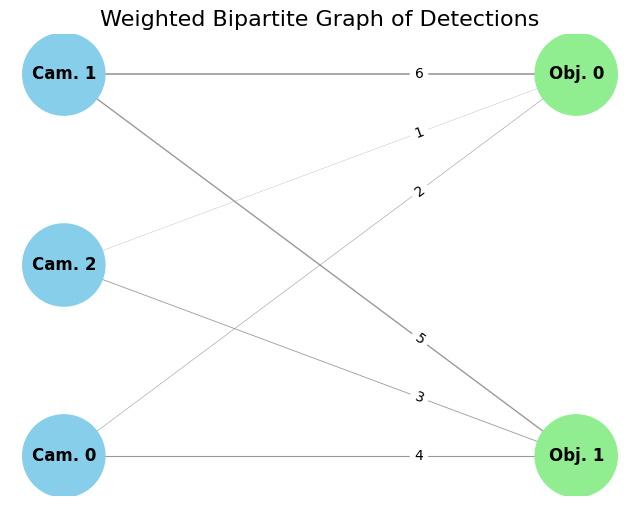

In [10]:
! pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create a graph object
G = nx.Graph()
# 2. Define the two sets of nodes (the partitions)
cameras = {f"Cam. {a.id}" for a in simulation_scene.cameras}
print(f"Camera IDs: {cameras}")
objects = {f"Obj. {a.id}" for a in simulation_scene.objects}
print(f"Object IDs: {objects}")
# 3. Add nodes to the graph, specifying which partition they belong to
G.add_nodes_from(cameras, bipartite=0) # Assign partition 0 to cameras
G.add_nodes_from(objects, bipartite=1) # Assign partition 1 to objects

# 4. Add edges connecting nodes from one partition to the other
edge_weights = defaultdict(int)
for timestep_data in visibility_scores:
    # print(f"{timestep_data=}")
    for obj_id, camera_data in timestep_data.items():
        for cam_id, hits in camera_data.items():
            edge_weights[(f'Cam. {cam_id}', f'Obj. {obj_id}')] += hits

# 5. Create a list of weighted edge tuples: (node1, node2, weight)
weighted_edge_list = []
for (cam, obj), weight in edge_weights.items():
    weighted_edge_list.append((cam, obj, weight))
print(f"Weighted Edges: {weighted_edge_list}")

# Add the weighted edges to the graph
G.add_weighted_edges_from(weighted_edge_list)

# 5. Get the positions for a bipartite layout
# This is the crucial step for a clean visualization
pos = nx.bipartite_layout(G, cameras)

# 6. Draw the graph
plt.figure(figsize=(8, 6))


node_colors = ['skyblue' if n in cameras else 'lightgreen' for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# 4. Draw the edges with variable thickness
# Extract weights and scale them for better visualization
all_weights = [G[u][v]['weight'] for u, v in G.edges()]
# We scale the weights (e.g., divide by 5) so the lines aren't too thick
scaled_widths = [w / 5.0 for w in all_weights]

nx.draw_networkx_edges(G, pos, width=scaled_widths, edge_color='gray', alpha=0.8)
# 5. Draw the edge labels to show the numeric weight
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_color='black',
    font_size=10,
    label_pos=0.7 # <-- Add this line to shift labels off-center
)
plt.title("Weighted Bipartite Graph of Detections", fontsize=16)
plt.box(False) # Remove the plot frame
plt.show()

This is a simple example using the number or rays as a visibility metric. More rays on a certain object means more visibility.

Cases where this visibility metric (# of rays) is not a good representation.
* The visibility metric based on the number of rays intersecting an object can be misleading in certain scenarios. For example, when a camera is positioned close to an object, a large number of rays may collide with the object but remain concentrated in a small area, providing detailed coverage of that specific region while leaving the rest of the object unobserved. Conversely, if the same number of rays were distributed sparsely across the object, the visibility metric would remain identical, despite the two cases having fundamentally different implications. The concentrated rays offer localized detail, whereas the sparse distribution provides broader coverage, highlighting the metric’s inability to account for spatial distribution.

Here, we keep the visibility metric as is and use this metric for doing calculations further down. 


### The problem scenario.

In a known environment, we want to place $K$ static cameras so that the visibility of the dynamic objects $O$ inside that environment is maximized. The dynamic object here has a known trajectory. 

### Problem Formulation

Given:  
$O = \{o_1, o_2, \dots, o_N\}, \quad C = \{c_1, c_2, \dots, c_K\}$  

Each object $o_i$ has a position at timestep $t$ represented as:  
$$
p_i(t) = (x_i(t), y_i(t), \theta_i(t))
$$  
where:  
- $x_i(t)$ and $y_i(t)$ are the 2D coordinates of the object $o_i$ at time $t$.  
- $\theta_i(t)$ is the orientation (angle) of the object $o_i$ at time $t$.  

The path trajectory $P$ of object $o_i$ over all timesteps is expressed as:  
$$
P_i = \{p_i(0), p_i(1), \dots, p_i(T)\}
$$  

With the path trajectory also known as a prior, we aim to find the placement of $K$ cameras $C$ such that:  
$$
\max V(C, O, P)
$$  

where $V$ represents the visibility of the objects $O$ along their path trajectories $P$ with cameras $C$.


$$
\max V = \sum_{t=0}^{T} \sum_{i=1}^{N} \sum_{j=1}^{K} v(o_i, c_j, t)
$$  


In [13]:
print("#"*100)
print("#"*100)
print("#"*100)

####################################################################################################
####################################################################################################
####################################################################################################


### Getting candidate sets of positions
First, we generate a set of locations for possible camera placement. We make a grid of possible camera locations. 
Exclude locations outside the polygon environment. Exclude positions that overlap with the object.

🔍 Generating a grid of possible camera locations...
✅ Found 303 valid camera locations.


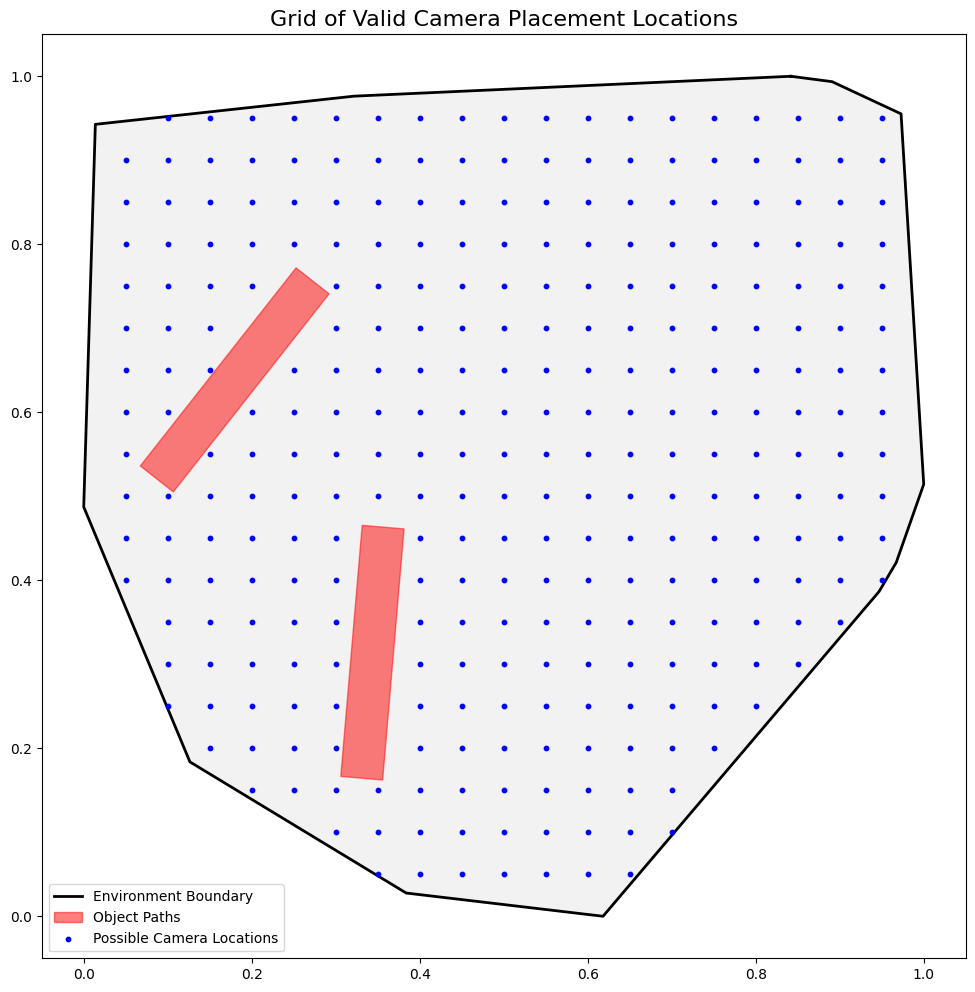

In [7]:

# --- Configuration ---
# Define the spacing between points in the grid. Smaller values = denser grid.
GRID_SPACING = 0.05

print("🔍 Generating a grid of possible camera locations...")

# 1. Get the necessary components from the existing scene
environment_polygon = simulation_scene.env.polygon
all_future_obstacles = [shape for obj in simulation_scene.objects for shape in obj.shapes]
minx, miny, maxx, maxy = environment_polygon.bounds

# 2. Create a list to store valid locations
possible_camera_locations = []

# 3. Iterate over the grid defined by the environment's bounding box
for x in np.arange(minx, maxx, GRID_SPACING):
    for y in np.arange(miny, maxy, GRID_SPACING):
        # Create a Shapely Point for the current grid location
        point = Point(x, y)
        
        # 4. Check if the point is valid
        # Condition 1: Must be inside the environment boundary
        is_in_env = environment_polygon.contains(point)
        # Condition 2: Must not be on any object's path
        is_on_obstacle = any(obs.contains(point) for obs in all_future_obstacles)
        
        if is_in_env and not is_on_obstacle:
            possible_camera_locations.append(point)

print(f"✅ Found {len(possible_camera_locations)} valid camera locations.")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Environment
x, y = environment_polygon.exterior.xy
ax.plot(x, y, color='black', linewidth=2, label='Environment Boundary')
ax.fill(x, y, alpha=0.1, color='grey')

# Plot Obstacle Paths
# We can use a single MultiPolygon for efficiency
from shapely.ops import unary_union
obstacle_union = unary_union(all_future_obstacles)
if obstacle_union.geom_type == 'MultiPolygon':
    for poly in obstacle_union.geoms:
        ox, oy = poly.exterior.xy
        ax.fill(ox, oy, alpha=0.5, color='red', label='Object Paths')
else:
    ox, oy = obstacle_union.exterior.xy
    ax.fill(ox, oy, alpha=0.5, color='red', label='Object Paths')


# Plot Possible Camera Locations
cam_x = [p.x for p in possible_camera_locations]
cam_y = [p.y for p in possible_camera_locations]
ax.scatter(cam_x, cam_y, s=10, color='blue', label='Possible Camera Locations', zorder=5)

ax.set_aspect('equal', adjustable='box')
ax.set_title("Grid of Valid Camera Placement Locations", fontsize=16)

# Create a clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

Now, we calculate the visibility for each camera position.



Calculating visibility for all 303 potential locations...
  -> 📷 Camera created at (0.05, 0.40).
  -> 📷 Camera created at (0.05, 0.45).
  -> 📷 Camera created at (0.05, 0.50).
  -> 📷 Camera created at (0.05, 0.55).
  -> 📷 Camera created at (0.05, 0.60).
  -> 📷 Camera created at (0.05, 0.65).
  -> 📷 Camera created at (0.05, 0.70).
  -> 📷 Camera created at (0.05, 0.75).
  -> 📷 Camera created at (0.05, 0.80).
  -> 📷 Camera created at (0.05, 0.85).
  -> 📷 Camera created at (0.05, 0.90).
  -> 📷 Camera created at (0.10, 0.25).
  -> 📷 Camera created at (0.10, 0.30).
  -> 📷 Camera created at (0.10, 0.35).
  -> 📷 Camera created at (0.10, 0.40).
  -> 📷 Camera created at (0.10, 0.45).
  -> 📷 Camera created at (0.10, 0.50).
  -> 📷 Camera created at (0.10, 0.60).
  -> 📷 Camera created at (0.10, 0.65).
  -> 📷 Camera created at (0.10, 0.70).
  -> 📷 Camera created at (0.10, 0.75).
  -> 📷 Camera created at (0.10, 0.80).
  -> 📷 Camera created at (0.10, 0.85).
  -> 📷 Camera created at (0.10, 0.90).
  -> 📷

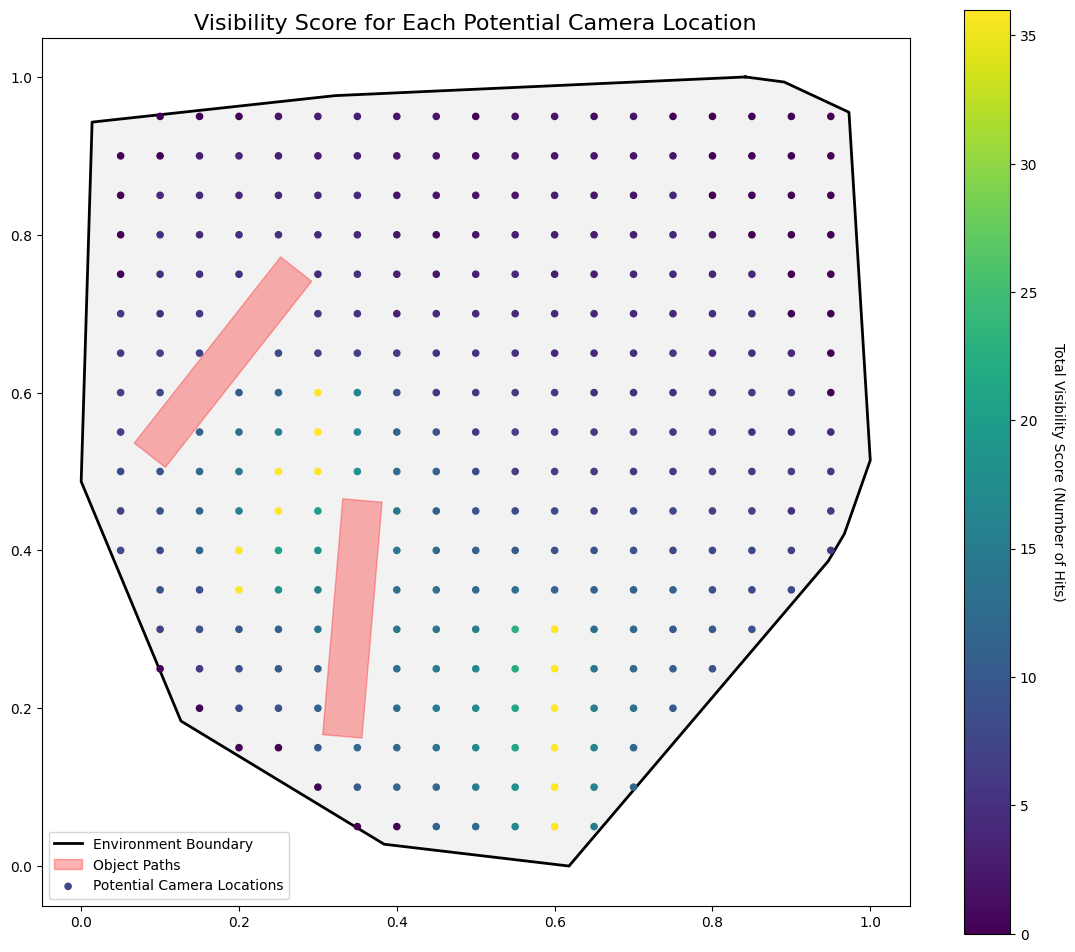

In [14]:


print(f"Calculating visibility for all {len(possible_camera_locations)} potential locations...")

# 1. Store the original cameras to restore them later
original_cameras = simulation_scene.cameras

# 2. Prepare a list to hold the results
visibility_results = []

# This dictionary will store the aggregated score for each camera location
# Structure: {location_point: total_score}
location_scores = defaultdict(int)

# 3. Iterate over every possible camera location
for i, location_point in enumerate(possible_camera_locations):
    # Create a temporary scene with only ONE camera at the current location
    temp_camera = Camera(location_point, camera_id=999) # ID doesn't matter here
    simulation_scene.cameras = [temp_camera]
    
    # We need a calculator for this temporary scene
    temp_calculator = VisibilityCalculator(simulation_scene)
    
    # 4. Run the simulation for this single camera placement
    total_hits_for_location = 0
    for t in range(simulation_scene.num_timesteps):
        simulation_scene.update_scene_at_timestep(t)
        # Calculate scores for this timestep
        scores_at_t = temp_calculator.calculate_at_timestep()
        
        # Aggregate the hits from all objects at this timestep
        for obj_id, camera_data in scores_at_t.items():
            for cam_id, hits in camera_data.items():
                total_hits_for_location += hits
                
    # 5. Store the total aggregated score for this location
    location_scores[location_point] = total_hits_for_location
    
    # Optional: Print progress
    if (i + 1) % 50 == 0:
        print(f"  ...processed {i + 1}/{len(possible_camera_locations)} locations.")

# 6. Restore the original cameras to the scene object
simulation_scene.cameras = original_cameras

print(f"\n✅ Visibility calculation complete.")

# --- Convert results for visualization ---
locations = list(location_scores.keys())
scores = list(location_scores.values())

# Create a colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(scores), vmax=max(scores))
colors = [cmap(norm(score)) for score in scores]

# --- Visualization ---
fig, ax = plt.subplots(figsize=(14, 12))

# Plot Environment and Obstacle Paths (same as before)
x, y = environment_polygon.exterior.xy
ax.plot(x, y, color='black', linewidth=2, label='Environment Boundary')
ax.fill(x, y, alpha=0.1, color='grey')

if obstacle_union.geom_type == 'MultiPolygon':
    for poly in obstacle_union.geoms:
        ox, oy = poly.exterior.xy
        ax.fill(ox, oy, alpha=0.3, color='red', label='Object Paths')
else:
    ox, oy = obstacle_union.exterior.xy
    ax.fill(ox, oy, alpha=0.3, color='red', label='Object Paths')

# Plot Camera Locations with colors based on score
cam_x = [p.x for p in locations]
cam_y = [p.y for p in locations]
scatter = ax.scatter(cam_x, cam_y, c=colors, s=20, label='Potential Camera Locations', zorder=5)

# Add a colorbar to show the score mapping
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical')
cbar.set_label('Total Visibility Score (Number of Hits)', rotation=270, labelpad=20)

ax.set_aspect('equal', adjustable='box')
ax.set_title("Visibility Score for Each Potential Camera Location", fontsize=16)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

## The problem with single point ray hits as visibility

Single ray hits are a single point in the objects. Even if we have a very dense set of rays on the object, the point on the object right next to that "hit" point would be classified as "uncovered." In other words, the rays are not a good metric for "covered."

Instead we need a good metric that could be used both as a **visibility** metric and a **coverage** metric.